In [1]:
%%writefile task12.py
from mpi4py import MPI
from numpy import pi, exp, fft
import numpy as np
import time as  timer
import sys
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
amode = MPI.MODE_WRONLY|MPI.MODE_CREATE
fh_Z = MPI.File.Open(comm, "./Z.txt", amode)
fh_time = MPI.File.Open(comm, "./time.txt", amode)
fh_freq = MPI.File.Open(comm, "./freq_fft.txt", amode)
time0 = timer.time()

def generate_signal(N):
    t = np.linspace(-20 * 2 * pi, 20 * 2 * pi, N)
    y = np.sin(t) * exp(-(t**2) / 2 / 20**2)
    y = y + np.sin(3 * t) * exp(-((t - 5 * 2 * pi) ** 2) / 2 / 20**2)
    y = y + np.sin(5.5 * t) * exp(-((t - 10 * 2 * pi) ** 2) / 2 / 5**2)
    y = y + np.sin(4 * t) * exp(-((t - 7 * 2 * pi) ** 2) / 2 / 20**2)
    return y, t

def window_map(signal, time, window_position, window_width=2.0 * 2 * pi):
    return signal * exp(-((time - window_position) ** 2) / 2 / window_width**2)

N = 3**9 + 6
y, t = generate_signal(N)
freq_itter = 200
window_times_total = np.linspace(-20, 20,freq_itter,dtype=np.float32)

step = freq_itter // size
if rank == size - 1:
    window_times = window_times_total[step * rank :]
else:
    window_times = window_times_total[step * rank : step * (rank + 1)]


freq_fft = fft.fftfreq(len(y), d=(t[1] - t[0]) / 2 / pi)
freq_fft = freq_fft[: len(freq_fft) // 2]

fft_list = []


for time in window_times:
    window = window_map(y, t, time * 2 * pi)

    window_fft = fft.fft(window)
    window_fft = window_fft[: len(window_fft) // 2]
    window_fft = 2.0 / N * abs(window_fft)
    fft_list.append(window_fft)
    
Z = np.vstack(fft_list)
data = comm.gather(Z, root=0)

if rank == 0:
    Z = np.vstack(data)
    fh_Z.Write(Z)
    fh_time.Write(window_times_total)
    fh_freq.Write(freq_fft)
    

fh_Z.Close()
fh_time.Close()
fh_freq.Close()

print(timer.time() - time0)
MPI.Finalize()

Overwriting task12.py


In [2]:
!mpirun -n 5 python task12.py 

0.39249730110168457
0.39249086380004883
0.3924863338470459
0.39249110221862793
0.39249444007873535


In [3]:
import numpy as np
import matplotlib.pyplot as plt

time = np.fromfile("time.txt", dtype=np.float32)
freq = np.fromfile("freq_fft.txt", dtype=np.float64)
Z = np.fromfile("Z.txt", dtype=np.float64).reshape(time.shape[0], -1).T

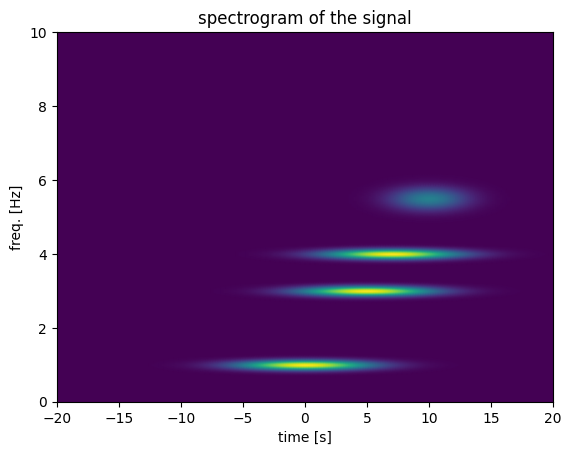

In [4]:
plt.pcolormesh(time, freq, Z, shading="gouraud")
plt.ylim(0, 10)
plt.title("spectrogram of the signal")
plt.ylabel("freq. [Hz]")
plt.xlabel("time [s]")
plt.show()

In [5]:
timer = []
processes = list(range(1,8))
for proc in processes:
    a = !mpirun -n {proc} python task12.py 
    timer.append(np.mean(np.array(a).astype(float)))

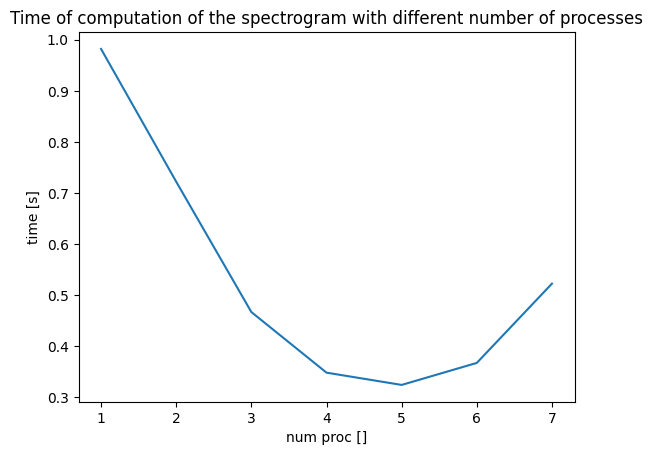

In [6]:
plt.plot(processes, timer)
plt.title("Time of computation of the spectrogram with different number of processes")
plt.xlabel("num proc []")
plt.ylabel("time [s]")
plt.show()